In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [3]:
DIRECTORY = r"C:\Users\Vineeth\Desktop\Covid_Face_mask_detector\RESOURCE"
CATEGORIES = ["img_mask", "img_nomask"]

In [4]:
data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(category)

C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [5]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=42)

In [7]:
vin_1 = ImageDataGenerator(rotation_range=20,zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.15,horizontal_flip=True,
fill_mode="nearest")

In [8]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

9412608/9406464 [==============================] - 4s 0us/step


In [9]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [10]:
model = Model(inputs=baseModel.input, outputs=headModel)


In [12]:
for layer in baseModel.layers:
    layer.trainable = False


In [13]:
print("[INFO] compiling model...")
model_optimizer = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=model_optimizer,metrics=["accuracy"])

[INFO] compiling model...


In [14]:
H = model.fit(vin_1.flow(trainX, trainY, batch_size=BS),steps_per_epoch=len(trainX) // BS,validation_data=(testX, testY),validation_steps=len(testX) // BS,
epochs=EPOCHS)

Epoch 1/20
113/113 [==============================] - 138s 1s/step - loss: 0.3034 - accuracy: 0.8672 - val_loss: 0.0897 - val_accuracy: 0.9769
Epoch 2/20
113/113 [==============================] - 137s 1s/step - loss: 0.0994 - accuracy: 0.9653 - val_loss: 0.0548 - val_accuracy: 0.9857
Epoch 3/20
113/113 [==============================] - 140s 1s/step - loss: 0.0675 - accuracy: 0.9775 - val_loss: 0.0429 - val_accuracy: 0.9890
Epoch 4/20
113/113 [==============================] - 142s 1s/step - loss: 0.0489 - accuracy: 0.9825 - val_loss: 0.0371 - val_accuracy: 0.9901
Epoch 5/20
113/113 [==============================] - 140s 1s/step - loss: 0.0481 - accuracy: 0.9817 - val_loss: 0.0363 - val_accuracy: 0.9901
Epoch 6/20
113/113 [==============================] - 132s 1s/step - loss: 0.0382 - accuracy: 0.9867 - val_loss: 0.0311 - val_accuracy: 0.9923
Epoch 7/20
113/113 [==============================] - 132s 1s/step - loss: 0.0365 - accuracy: 0.9878 - val_loss: 0.0298 - val_accuracy: 0.9934

In [15]:
predIdxs = model.predict(testX, batch_size=BS)


In [16]:
predIdxs = np.argmax(predIdxs, axis=1)


In [17]:
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))


              precision    recall  f1-score   support

    img_mask       0.99      0.99      0.99       521
  img_nomask       0.99      0.99      0.99       388

    accuracy                           0.99       909
   macro avg       0.99      0.99      0.99       909
weighted avg       0.99      0.99      0.99       909



In [20]:
model.save("covid_mask_detector.model", save_format="h5")


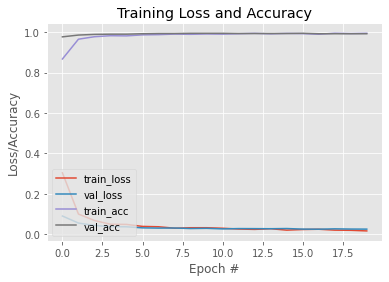

In [21]:
#plotting graph  for loss and accuracy..
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")